# Importing all Necessary Packages

In [2]:
# basic packages for data analysis & visualisations
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans

# packages for ML & text-mining
import nltk
from sklearn import metrics
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as lmt
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import GaussianNB
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

In [3]:
# read the data
brev = pd.read_excel('../input/banks-reviews/PrBankReviews.xlsx')

In [4]:
brev.head()

,Date,Stars,Reviews,BankName
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


In [5]:
brev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
Date        505 non-null datetime64[ns]
Stars       505 non-null int64
Reviews     505 non-null object
BankName    505 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.9+ KB


# Exploratory Data Analysis

In [6]:
# random review text
brev.Reviews[5]

'I had the pleasure of working with Wyndham Capital in September 2018 as my family and I were making a home purchase in Columbus, OH. From the original conversation with the loan officer to underwriting and all the way through closing, the entire team from Wyndham was very responsive and professional. I was VERY impressed with how smooth their process was and how timely the communication was given how stressful of a process home buying (and selling) can be'

In [7]:
# extracting month & year from date var
brev['year'] = brev.Date.apply(lambda d : d.year)
brev['month'] = brev.Date.apply(lambda d : d.month)

(-1.25, 1.25, -1.25, 1.25)

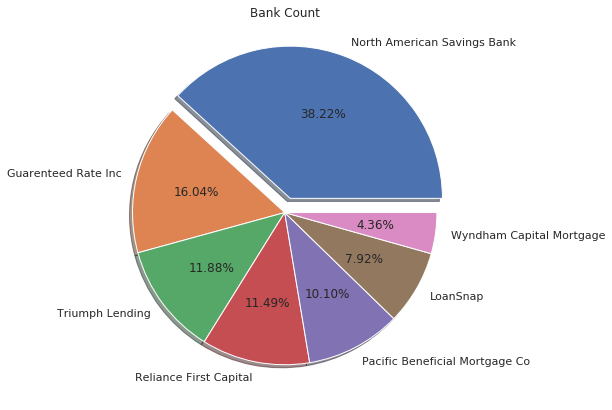

In [8]:
# pie plot showing banks of which reviews have been written
sns.set(style='whitegrid')
brev.BankName.value_counts().plot(kind='pie', title='Bank Count', autopct='%.2f%%', figsize=(14,7), shadow=True, explode=[0.1,0,0,0,0,0,0])
plt.axis('off')

**From the pie plot it is clear that **

* 38% of the reviews are of North American Savings Bank
    * this also indicates most reviewers are customers of North American bank


* the second highest is that of Guaranteed Rate inc. followed by Triumph Lending and Reliance Capital

* Whyndham Capital has least reviews

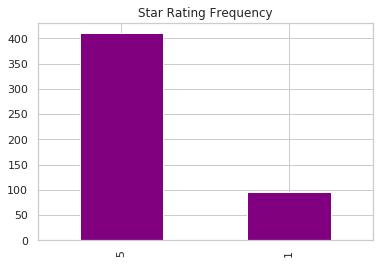

In [9]:
#sns.countplot(brev.Stars)
ax = brev.Stars.value_counts().plot.bar(color='Purple',title='Star Rating Frequency')

The plot indicates that most of the reviewers rated 5 starts to their banks, while only few gave 1 star rating

Text(0.5, 0, '')

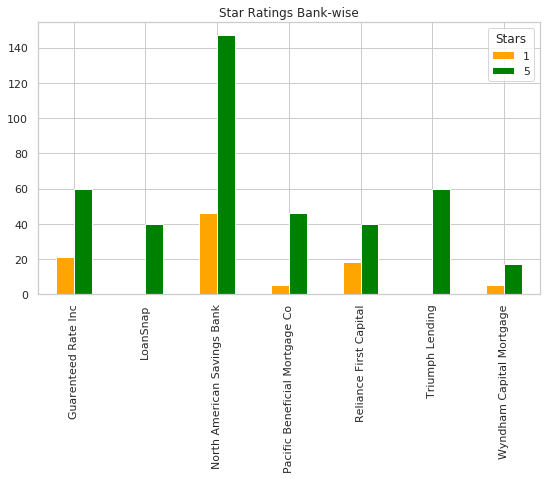

In [10]:
# plot showing bank-wise star ratings
brev.groupby('BankName').Stars.value_counts().unstack().plot(kind='bar', title = 'Star Ratings Bank-wise', color=['Orange','Green'], figsize=(9,5))
plt.xlabel('')

**From the above plot we can infer that**
* Loan Snap & Triumph Lending have no negative reviews / 1 stars
* No bank has negative reviews / 1 star more than 5 stars
* In terms of absolute numbers - North American Bank has most 1 star rating, however its 5 star rating frequency towers other bank's

Text(0.5, 1.0, 'Monthly Review Counts (Year wise)')

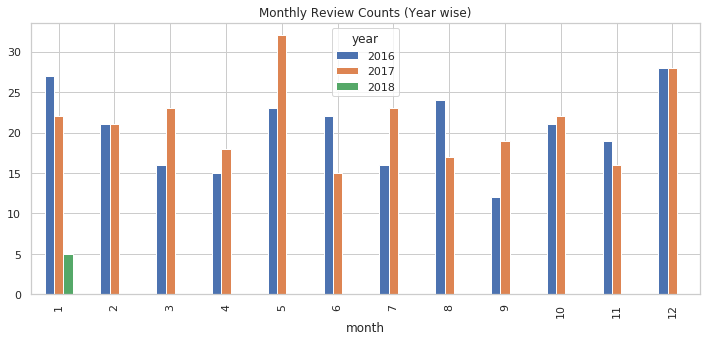

In [11]:
# plot showing review distribution over time period
df1 = brev.groupby(['month','year']).Reviews.count().unstack()
df1.plot(kind='bar', figsize=(12,5))
plt.title('Monthly Review Counts (Year wise)')

**From the plot we conclude that**
* Most reviews were given in the month of May and December
* for the year 2018, reviews are available only for January
* In general, most reviews were given throughout the year 2017

In [12]:
#STOPWORDS from NLTK
stopeng = set(stopwords.words('english'))  # stopeng contains all english stopwords from NLTK lib.

In [13]:
dfrev = brev.copy()
#dfrev['Reviews'] = dfrev.Reviews.astype(str)

# word count
dfrev['Word Count'] = dfrev.Reviews.apply(lambda t : len(str(t).split()))

#title case words
dfrev['Title words'] = dfrev.Reviews.apply(lambda t :len([w for w in str(t).split() if w.istitle()]))

#upper case words count
dfrev['UpperCase words'] = dfrev.Reviews.apply(lambda t :len([w for w in str(t).split() if w.isupper()]))

#upper case words count
dfrev['LowerCase words'] = dfrev.Reviews.apply(lambda t :len([w for w in str(t).split() if w.islower()]))

# numeric count
dfrev['Digit Count'] = dfrev.Reviews.apply(lambda t :len([w for w in t.split() if w.isdigit()]))

#converting all to lower case
dfrev['Reviews'] = dfrev.Reviews.apply(lambda t : t.lower())

# unique word count
dfrev['Unique Word'] = dfrev.Reviews.apply(lambda t : len(set(t.split())))

#stopwords count
dfrev['Stopwrd Count'] = dfrev.Reviews.apply(lambda t : len([w for w in str(t).split() if w in stopeng]))

In [14]:
#mapping different parts of speech available under textblob
pos = {'noun'      :['NN','NNS','NNP','NNPS'],
       'verb'      :['VB','VBD','VBG','VBN','VBP','VBZ'],
       'pronoun'   :['PRP','PRP$','WP','WP$'],
       'adverb'    :['RB','RBR','RBS','WRB'],
       'adjective' :['JJ','JJR','JJS']}

def postag(t, part):   #UDF for counting tags
    c=0
    tt = TextBlob(t)
    for i in tt.tags:
        j=list(i)[1]
        if j in pos[part]:
            c=c+1
    return c

dfrev['nn_count']   = dfrev['Reviews'].apply(lambda x: postag(x, 'noun'))
dfrev['vb_count']   = dfrev['Reviews'].apply(lambda x: postag(x, 'verb'))
dfrev['adj_count']  = dfrev['Reviews'].apply(lambda x: postag(x, 'pronoun'))
dfrev['adv_count']  = dfrev['Reviews'].apply(lambda x: postag(x, 'adverb'))
dfrev['prn_count']  = dfrev['Reviews'].apply(lambda x: postag(x, 'adjective'))

In [15]:
dfrev

,Date,Stars,Reviews,BankName,year,month,Word Count,Title words,UpperCase words,LowerCase words,Digit Count,Unique Word,Stopwrd Count,nn_count,vb_count,adj_count,adv_count,prn_count
0,2017-04-10,5,"great job, wyndham capital! each person was pr...",Wyndham Capital Mortgage,2017,4,19,5,0,14,0,19,5,6,3,3,1,3
1,2017-02-10,5,matthew richardson is professional and helpful...,Wyndham Capital Mortgage,2017,2,25,5,0,20,0,23,10,7,3,4,2,4
2,2017-08-21,5,we had a past experience with wyndham mortgage...,Wyndham Capital Mortgage,2017,8,79,14,0,64,0,62,31,19,11,8,8,8
3,2017-12-17,5,we have been dealing with brad thomka from the...,Wyndham Capital Mortgage,2017,12,108,18,0,88,0,76,49,25,18,11,7,12
4,2016-05-27,5,i can't express how grateful i am for the supp...,Wyndham Capital Mortgage,2016,5,59,9,3,50,0,47,30,18,8,5,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,2016-02-06,1,\r\ni never write reviews but had to this time...,North American Savings Bank,2016,2,455,49,26,402,0,220,242,120,102,33,18,34
501,2016-07-25,1,\r\nit all started when bob g ran a credit che...,North American Savings Bank,2016,7,164,22,13,135,2,106,80,36,40,14,12,8
502,2017-09-27,1,\r\nwhat a horrible experience. we have excell...,North American Savings Bank,2017,9,135,6,2,125,1,107,63,27,22,11,17,16
503,2017-12-24,1,"\r\nrep was extremely professional, friendly, ...",North American Savings Bank,2017,12,211,25,17,179,0,141,103,47,43,20,19,20


# Reviews Sentiment Analysis

In [16]:
sent = dfrev[['Stars','Reviews']].copy()
sent

,Stars,Reviews
0,5,"great job, wyndham capital! each person was pr..."
1,5,matthew richardson is professional and helpful...
2,5,we had a past experience with wyndham mortgage...
3,5,we have been dealing with brad thomka from the...
4,5,i can't express how grateful i am for the supp...
...,...,...
500,1,\r\ni never write reviews but had to this time...
501,1,\r\nit all started when bob g ran a credit che...
502,1,\r\nwhat a horrible experience. we have excell...
503,1,"\r\nrep was extremely professional, friendly, ..."


### Classifying reviews into POS, NEG & Neut

This is done based on the TextBlob polarity score

* TextBlob polarity = 0.05 for neutral review
* TextBlob polarity < 0.05 for negative review
* TextBlob polarity > 0.05 for positive review

In [17]:
sent['polarity'] = sent.Reviews.apply(lambda t : TextBlob(t).sentiment.polarity)
sent

,Stars,Reviews,polarity
0,5,"great job, wyndham capital! each person was pr...",0.533333
1,5,matthew richardson is professional and helpful...,0.453333
2,5,we had a past experience with wyndham mortgage...,-0.033231
3,5,we have been dealing with brad thomka from the...,0.093740
4,5,i can't express how grateful i am for the supp...,0.125000
...,...,...,...
500,1,\r\ni never write reviews but had to this time...,0.122289
501,1,\r\nit all started when bob g ran a credit che...,0.139815
502,1,\r\nwhat a horrible experience. we have excell...,0.071667
503,1,"\r\nrep was extremely professional, friendly, ...",0.176042


In [18]:
cond = [sent.polarity<0.05, sent.polarity==0.05, sent.polarity>0.05]
choice = ['Neg', 'Neut', 'Pos']
sent['Review Type'] = np.select(cond,choice)
#sent.drop(columns=['polarity'],inplace=True)

In [19]:
sent

,Stars,Reviews,polarity,Review Type
0,5,"great job, wyndham capital! each person was pr...",0.533333,Pos
1,5,matthew richardson is professional and helpful...,0.453333,Pos
2,5,we had a past experience with wyndham mortgage...,-0.033231,Neg
3,5,we have been dealing with brad thomka from the...,0.093740,Pos
4,5,i can't express how grateful i am for the supp...,0.125000,Pos
...,...,...,...,...
500,1,\r\ni never write reviews but had to this time...,0.122289,Pos
501,1,\r\nit all started when bob g ran a credit che...,0.139815,Pos
502,1,\r\nwhat a horrible experience. we have excell...,0.071667,Pos
503,1,"\r\nrep was extremely professional, friendly, ...",0.176042,Pos


In [20]:
sent[sent['Review Type']=='Pos'][4:6] # some positive reviews

,Stars,Reviews,polarity,Review Type
5,5,i had the pleasure of working with wyndham cap...,0.345833,Pos
6,5,my experience with mattison was beyond greatly...,0.313281,Pos


In [21]:
sent[sent['Review Type']=='Neg'][4:6] # some negative reviews

,Stars,Reviews,polarity,Review Type
44,1,this lender contacted my previous phone number...,-0.205556,Neg
45,1,i never write reviews but had to this time to ...,-0.045000,Neg


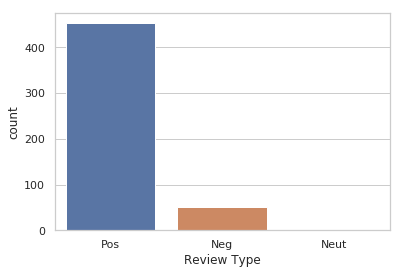

In [22]:
sns.countplot(sent['Review Type'])

* Majority of the reviews are positive, while very few are negative.

# Finding Key Positive & Negative words

**Approach** : I have used 2 files - list of all positive sentiment words and list of all negative sentiment words compiled by Minqing Hu and Bing Lu for their research dealing with sentiment analysis of social media texts. 

The sentiment words can be found [here](https://github.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/tree/master/data/opinion-lexicon-English)

I have cleaned the reviews and, and search if those words are present in the said positive or negative sentiment list and assigning them accordingly.

In [23]:
# reading positive sentiment words file
with open('../input/posneg/pos.txt') as f:
    p_txt=f.read()
    
p_list = p_txt.replace('\n',' ').replace('  ',' ').lower().split()

In [24]:
p_list[1:10] # some positive sentiment words

['abound',
 'abounds',
 'abundance',
 'abundant',
 'accessable',
 'accessible',
 'acclaim',
 'acclaimed',
 'acclamation']

In [25]:
print('amazing' in p_list)
print('danger' in p_list)

True
False


In [26]:
# reading negative sentiment words file
with open('../input/posneg/neg.txt', encoding="ISO-8859-1") as f:
    n_txt=f.read()
    
n_list = n_txt.replace('\n',' ').replace('  ',' ').lower().split()

In [27]:
n_list[1:10] # some negative sentiment words

['2-faces',
 'abnormal',
 'abolish',
 'abominable',
 'abominably',
 'abominate',
 'abomination',
 'abort',
 'aborted']

In [28]:
print('amazing' in n_list)
print('danger' in n_list)

False
True


In [29]:
# basic text cleaning
def review_cleaner(t):
    t = t.lower()
    t = t.strip()
    t = re.sub(r'\n',' ',t)
    t = re.sub(r'  ',' ',t)
    t = re.sub(r"[-()\"#/@;:{}`+=~|.!?,'0-9]", "", t)
    return t

sent['edit_rev'] = sent.Reviews.apply(lambda t :review_cleaner(t))

In [30]:
sent

,Stars,Reviews,polarity,Review Type,edit_rev
0,5,"great job, wyndham capital! each person was pr...",0.533333,Pos,great job wyndham capital each person was prof...
1,5,matthew richardson is professional and helpful...,0.453333,Pos,matthew richardson is professional and helpful...
2,5,we had a past experience with wyndham mortgage...,-0.033231,Neg,we had a past experience with wyndham mortgage...
3,5,we have been dealing with brad thomka from the...,0.093740,Pos,we have been dealing with brad thomka from the...
4,5,i can't express how grateful i am for the supp...,0.125000,Pos,i cant express how grateful i am for the suppo...
...,...,...,...,...,...
500,1,\r\ni never write reviews but had to this time...,0.122289,Pos,i never write reviews but had to this time to ...
501,1,\r\nit all started when bob g ran a credit che...,0.139815,Pos,it all started when bob g ran a credit check w...
502,1,\r\nwhat a horrible experience. we have excell...,0.071667,Pos,what a horrible experience we have excellent c...
503,1,"\r\nrep was extremely professional, friendly, ...",0.176042,Pos,rep was extremely professional friendly and he...


In [31]:
# UDF for finding positive and negative sentiment words from the reviews text

def pos_finder(t):
    pos_words=[]
    pos_words.extend([i for i in t.split() if i in p_list])
    return pos_words
    
def neg_finder(t):
    neg_words=[]
    neg_words.extend([i for i in t.split() if i in n_list])
    return neg_words

In [32]:
pos_words_list = sent.edit_rev.apply(lambda v : pos_finder(v))
neg_words_list = sent.edit_rev.apply(lambda v : neg_finder(v))

In [33]:
pos_words_list.to_list()[1:10]  # this is a list within a list/nested list showing positive words

[['helpful', 'helped', 'correct', 'thank', 'excellent'],
 ['right', 'recommend'],
 ['happy', 'right', 'indebted', 'recommend'],
 ['grateful', 'support', 'recommend'],
 ['pleasure', 'responsive', 'impressed', 'smooth', 'timely'],
 ['top', 'top', 'wonderful'],
 ['right', 'easy', 'pleased'],
 ['loved', 'knowledgeable'],
 ['great', 'willingness']]

In [34]:
neg_words_list.to_list()[2:12]    # this too is a list within a list/nested list

[['wrong'],
 ['stressful', 'wrong'],
 [],
 ['stressful'],
 ['misunderstanding'],
 [],
 ['lost', 'negative'],
 ['concerns'],
 [],
 ['stiff', 'lifeless', 'scary']]

In [35]:
from functools import reduce
pos_words_list2 = reduce(lambda x,y: x+y, pos_words_list)  # reducing nested list to simple lists
neg_words_list2 = reduce(lambda x,y: x+y, neg_words_list)

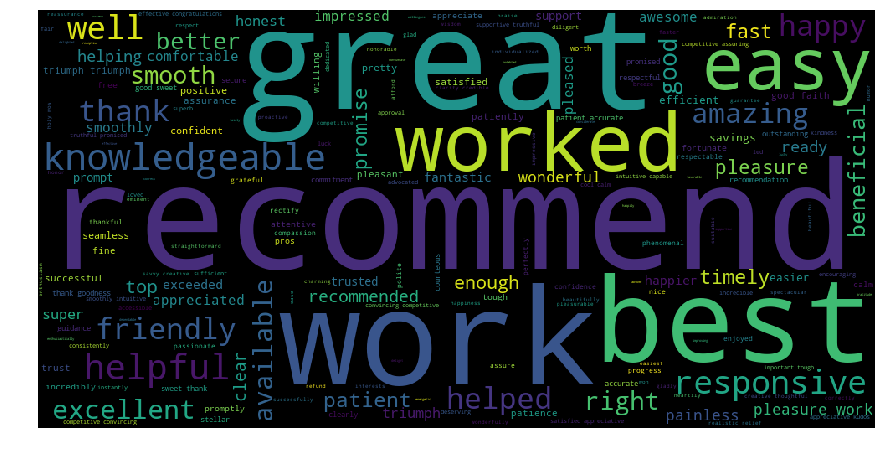

In [36]:
# creating wordcloud of most frequent positive sentiment words
unique_string=(" ").join(pos_words_list2)
wordcloud = WordCloud(width = 1000, height = 500, background_color='black').generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

from a glance of the above wordcloud, we can say that :
* "recommend", "great", "best", "easy", "excellent", "knowledgable", "helpful" etc. are some of the most used positive sentiment words.

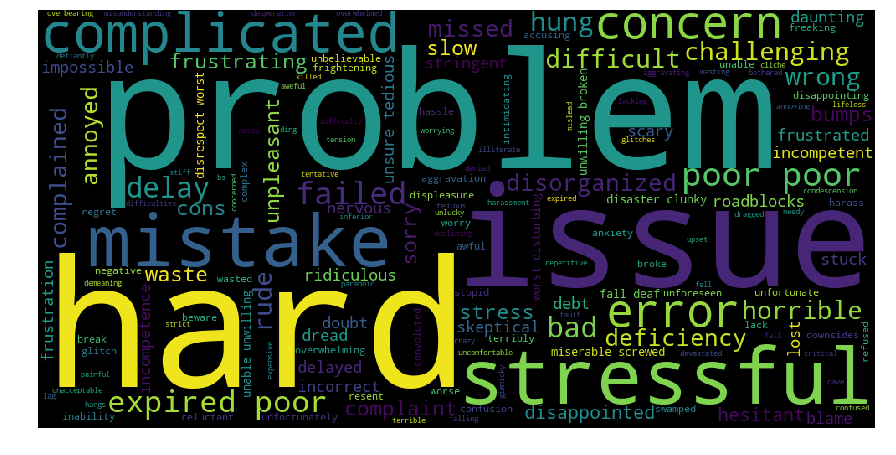

In [37]:
# creating wordcloud of most frequent negative sentiment words
unique_string=(" ").join(neg_words_list2)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

From the above wordcloud it is clear that :
* "problem", "hard", "stressful", "mistake", "issue", "complicated" are few of the most used negative sentiment words

In [38]:
len(set(neg_words_list2))  # set of negative sentiment words from the reviews

171

In [39]:
len(set(pos_words_list2))   # set of positive sentiment words from the reviews

257

## Predicting Star Rating Using Reviews

In [40]:
sent

,Stars,Reviews,polarity,Review Type,edit_rev
0,5,"great job, wyndham capital! each person was pr...",0.533333,Pos,great job wyndham capital each person was prof...
1,5,matthew richardson is professional and helpful...,0.453333,Pos,matthew richardson is professional and helpful...
2,5,we had a past experience with wyndham mortgage...,-0.033231,Neg,we had a past experience with wyndham mortgage...
3,5,we have been dealing with brad thomka from the...,0.093740,Pos,we have been dealing with brad thomka from the...
4,5,i can't express how grateful i am for the supp...,0.125000,Pos,i cant express how grateful i am for the suppo...
...,...,...,...,...,...
500,1,\r\ni never write reviews but had to this time...,0.122289,Pos,i never write reviews but had to this time to ...
501,1,\r\nit all started when bob g ran a credit che...,0.139815,Pos,it all started when bob g ran a credit check w...
502,1,\r\nwhat a horrible experience. we have excell...,0.071667,Pos,what a horrible experience we have excellent c...
503,1,"\r\nrep was extremely professional, friendly, ...",0.176042,Pos,rep was extremely professional friendly and he...


In [41]:
# PRE-PROCESSING

# stopword removal
sent.edit_rev = sent.edit_rev.apply(lambda t : ' '.join(c for c in t.split() if c not in stopeng)) # join with spaces those words not in stopwords list

#replace numbers
sent.edit_rev = sent.edit_rev.apply(lambda t :re.sub(r'[0-9]+', '',t))  # remove one or more numbers occuring together

In [42]:
# doing train-test split
X = sent.edit_rev
y = sent.Stars

train_x, test_x, train_y, test_y = train_test_split(X,y, test_size=0.3, random_state=12345)

In [43]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(353,)
(353,)
(152,)
(152,)


In [44]:
# for tokenization - creating unigrams
cvect = CountVectorizer(analyzer='word' ,ngram_range=(1, 1), encoding='latin-1')

In [45]:
trainx_cnt = cvect.fit_transform(train_x)

In [46]:
trainx_cnt

<353x2211 sparse matrix of type '<class 'numpy.int64'>'
	with 11296 stored elements in Compressed Sparse Row format>

In [47]:
train_x_dtm = pd.DataFrame(trainx_cnt.toarray(), columns = cvect.get_feature_names())
train_x_dtm   # term frequency matrix

,aaron,aarons,ability,able,absoltely,absolute,absolutely,accept,acceptable,accepted,...,wrong,wyndham,xx,year,years,yelp,yet,you,youi,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
350,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
351,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# similarly transforming test data into dtm
testx_cnt = cvect.transform(test_x)
testx_cnt

<152x2211 sparse matrix of type '<class 'numpy.int64'>'
	with 4953 stored elements in Compressed Sparse Row format>

In [49]:
test_x_dtm = pd.DataFrame (testx_cnt.toarray(), columns = cvect.get_feature_names())
test_x_dtm

,aaron,aarons,ability,able,absoltely,absolute,absolutely,accept,acceptable,accepted,...,wrong,wyndham,xx,year,years,yelp,yet,you,youi,zero
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
148,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150,1,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# using GaussianNB for classification

gauss = GaussianNB()   # using gaussian as our target is binary - either 5 or 1 star
gauss.fit(train_x_dtm, train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [51]:
train_pred_gnb = gauss.predict(train_x_dtm)
test_pred_gnb = gauss.predict(test_x_dtm)

Text(0.5, 0.98, 'Confusion Matrices - DTM(tf) used')

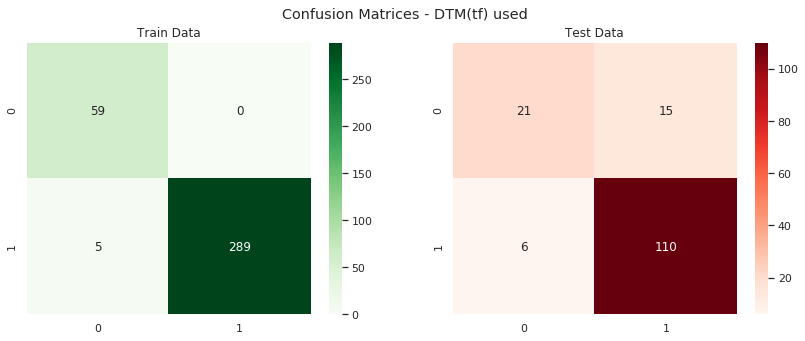

In [52]:
from sklearn import metrics
f,ax = plt.subplots(1,2, figsize=(14,5))
sns.heatmap(metrics.confusion_matrix(train_y, train_pred_gnb), annot=True, fmt='d', cmap='Greens',ax=ax[0])
ax[0].set_title('Train Data')
sns.heatmap(metrics.confusion_matrix(test_y, test_pred_gnb), annot=True, fmt='d', cmap='Reds',ax=ax[1])
ax[1].set_title('Test Data')
plt.suptitle('Confusion Matrices - DTM(tf) used')

Text(0.5, 1.0, 'Accuracy Scores (DTM) (Green=Train & Red = Test)')

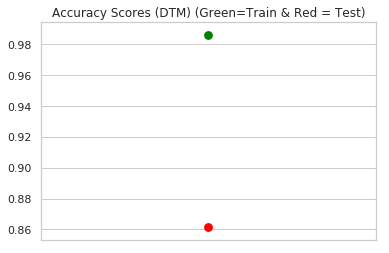

In [53]:
sns.pointplot(y=[metrics.accuracy_score(train_y, train_pred_gnb)], color='Green', label='Train')
sns.pointplot(y=[metrics.accuracy_score(test_y, test_pred_gnb)], color = 'Red', label='Test')
plt.title('Accuracy Scores (DTM) (Green=Train & Red = Test)')

In [54]:
# creating tf-idf for train and tests
tfidf_trans = TfidfTransformer()
train_x_tfidf = tfidf_trans.fit_transform(trainx_cnt)

In [55]:
train_x_tfidf

<353x2211 sparse matrix of type '<class 'numpy.float64'>'
	with 11296 stored elements in Compressed Sparse Row format>

In [56]:
train_x_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [57]:
# similarly creating tfidf for test data
test_x_tfidf = tfidf_trans.transform(testx_cnt)

In [58]:
train_x_tdm = pd.DataFrame(train_x_tfidf.toarray(), columns = cvect.get_feature_names())
train_x_tdm # this is tf-idf mat.

,aaron,aarons,ability,able,absoltely,absolute,absolutely,accept,acceptable,accepted,...,wrong,wyndham,xx,year,years,yelp,yet,you,youi,zero
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.215367,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.259893,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.100331,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
349,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
350,0.0,0.0,0.0,0.137792,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
351,0.0,0.0,0.0,0.160248,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [59]:
test_x_tdm = pd.DataFrame(test_x_tfidf.toarray(), columns = cvect.get_feature_names())
test_x_tdm

,aaron,aarons,ability,able,absoltely,absolute,absolutely,accept,acceptable,accepted,...,wrong,wyndham,xx,year,years,yelp,yet,you,youi,zero
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.307132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,0.000000,0.0,0.0,0.128209,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150,0.159254,0.0,0.0,0.228435,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
gauss2 = GaussianNB()
gauss2.fit(train_x_tdm, train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [61]:
train_pred_tdm = gauss2.predict(train_x_tdm)
test_pred_tdm = gauss2.predict(test_x_tdm)

Text(0.5, 0.98, 'Confusion Matrices - TDM(tfidf) used')

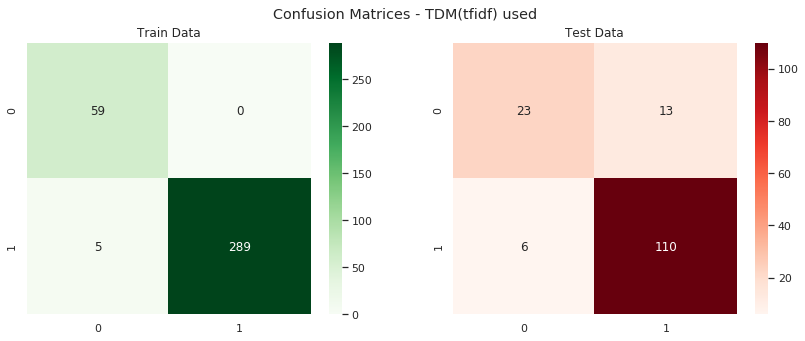

In [62]:
f,ax = plt.subplots(1,2, figsize=(14,5))
sns.heatmap(metrics.confusion_matrix(train_y, train_pred_tdm), annot=True, fmt='d', cmap='Greens', ax=ax[0])
ax[0].set_title('Train Data')
sns.heatmap(metrics.confusion_matrix(test_y, test_pred_tdm), annot=True, fmt='d', cmap='Reds', ax=ax[1])
ax[1].set_title('Test Data')
plt.suptitle('Confusion Matrices - TDM(tfidf) used')

Text(0.5, 1.0, 'Accuracy Scores (TDM) (Green=Train & Red = Test)')

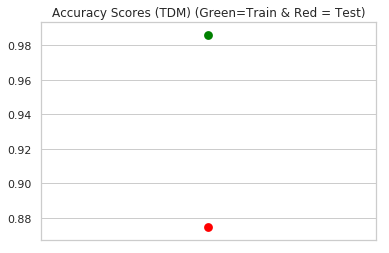

In [63]:
sns.pointplot(y=[metrics.accuracy_score(train_y,  train_pred_tdm)], color='Green', label='Train')
sns.pointplot(y=[metrics.accuracy_score(test_y, test_pred_tdm)], color = 'Red', label='Test')
plt.title('Accuracy Scores (TDM) (Green=Train & Red = Test)')

 From the above plots we infer that 
 * the accuracy and classification has imporoved slightly when we used tf-idf i.e. term frequency-inverse document frequency over simple term-frequency matrix

# Identifying Key Themes & Intent Analysis

### Using LDA for topic modelling 

**Approach :**  
* lemmetizing text before modelling

* for lemmetization I am using **"pywsd"** package which uses NLTK word lemmetizer to lemmetize entire sentences rather than word by word. It is based on the same approach as NLTK lemmetizer to which words to be lemmetized are sent as parameters, here sentences to be lemmetized are sent as parameters and returns list of lemmatized words.

* can be installed using  #pip install -U pywsd

In [64]:
pip install -U pywsd

     |████████████████████████████████| 26.8MB 3.2MB/s 
     |████████████████████████████████| 31.5MB 22.4MB/s 
  Created wheel for pywsd: filename=pywsd-1.2.4-cp36-none-any.whl size=26940452 sha256=e695d8e7c191e5cf85661fd648693c078288fbcf4af3f8c1216dc5a6cdb72901
  Stored in directory: /tmp/.cache/pip/wheels/71/4d/d2/405b948047f7f3851f16ab9d893ce7c1a3010182900884536b
  Created wheel for wn: filename=wn-0.0.22-cp36-none-any.whl size=31618502 sha256=6e628907d2e58a1eec4695115527632679c1eb8111bcfddc4ef5e26022712fe3
  Stored in directory: /tmp/.cache/pip/wheels/0c/71/8e/49271a2ce7d9a6e819766364a5329919868eba3cd31fab7086
Successfully built pywsd wn
Note: you may need to restart the kernel to use updated packages.


In [65]:
rev_text = sent.edit_rev.copy()

In [66]:
#rev_text = rev_text.apply(lambda t : t.split())
rev_text

0      great job wyndham capital person professional ...
1      matthew richardson professional helpful helped...
2      past experience wyndham mortgage would without...
3      dealing brad thomka beginning started stressfu...
4      cant express grateful support zach provided fa...
                             ...                        
500    never write reviews time prevent anyone making...
501    started bob g ran credit check without knowled...
502    horrible experience excellent credit plenty in...
503    rep extremely professional friendly helpful fi...
504    working loan consultant nasb told would give r...
Name: edit_rev, Length: 505, dtype: object

In [67]:
from pywsd.utils import lemmatize_sentence

rev_text_lemmed = rev_text.apply(lambda t : lemmatize_sentence(t))

Warming up PyWSD (takes ~10 secs)... took 7.143453359603882 secs.


In [68]:
rev_text_lemmed = rev_text_lemmed.apply(lambda t : " ".join(t))
rev_text_lemmed  # reviews after lemmetization

0      great job wyndham capital person professional ...
1      matthew richardson professional helpful help u...
2      past experience wyndham mortgage would without...
3      deal brad thomka beginning start stressful tim...
4      cant express grateful support zach provide fam...
                             ...                        
500    never write review time prevent anyone make mi...
501    start bob g run credit check without knowledge...
502    horrible experience excellent credit plenty in...
503    rep extremely professional friendly helpful fi...
504    work loan consultant nasb tell would give rate...
Name: edit_rev, Length: 505, dtype: object

In [69]:
tdfvect = TfidfVectorizer(min_df = 0.05, max_df = 0.95, ngram_range=(1,2), stop_words='english')
tdfvect.fit(rev_text_lemmed)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=None,
                min_df=0.05, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [70]:
rev_text_tfidf = tdfvect.transform(rev_text_lemmed)

In [71]:
# using latend dirichitlet allocation
lda_topic = LDA(n_components=3, learning_method='batch', max_iter=200, n_jobs=-1)  # 3 components or 3 topics/heads

In [72]:
rev_text_tfidf

<505x107 sparse matrix of type '<class 'numpy.float64'>'
	with 6268 stored elements in Compressed Sparse Row format>

In [73]:
text_topics = lda_topic.fit_transform(rev_text_tfidf)

In [74]:
topics = lda_topic.components_

In [75]:
topic_vocab = tdfvect.get_feature_names()

In [76]:
topic_vocab[1:15]

['answer',
 'answer question',
 'ask',
 'available',
 'bank',
 'begin',
 'best',
 'business',
 'buy',
 'care',
 'close',
 'closing',
 'come',
 'communication']

In [77]:
topic_summaries = []
for i, topic_dist in enumerate(topics):
    topic_words = np.array(topic_vocab)[np.argsort(topic_dist)][:-11:-1]
    topic_summaries.append(' '.join(topic_words))
topic_summaries

['home work time help best make close experience loan team',
 'process great question professional responsive helpful work knowledgeable answer highly',
 'company closing service loan lender customer mortgage rate email say']

TOPIC ANALYSIS :
* From the LDA results, we may conclude that the 3 topic heads under which reviews are allocated mainly deal with :
    * 1.  Bank functioning
    * 2.  Positive customer feedback, reviews
    * 3.  Loan, Bank rate, other credit related terms 

### Using KMeans for clustering

In [78]:
rev_text_tfidf

<505x107 sparse matrix of type '<class 'numpy.float64'>'
	with 6268 stored elements in Compressed Sparse Row format>

In [79]:
clusterer = KMeans(n_clusters = 6,n_init=1, max_iter=200, random_state=12345)

In [80]:
train_clustered = clusterer.fit(rev_text_tfidf)

In [81]:
train_clustered

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=200,
       n_clusters=6, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=12345, tol=0.0001, verbose=0)

In [82]:
vocabulary = tdfvect.get_feature_names()
vocabulary = np.array(vocabulary)

In [83]:
sorted_vals = [train_clustered.cluster_centers_[i].argsort() for i in range(0,np.shape(train_clustered.cluster_centers_)[0])]

In [84]:
words=set()
for i in range(len(train_clustered.cluster_centers_)):
    words = words.union(set(vocabulary[sorted_vals[i][-5:]]))
    print(words)

{'nasb', 'purchase', 'lender', 'experience', 'home'}
{'process', 'make', 'experience', 'home', 'nasb', 'time', 'rate', 'work', 'purchase', 'lender'}
{'question', 'process', 'make', 'experience', 'home', 'nasb', 'time', 'rate', 'work', 'great', 'purchase', 'responsive', 'lender'}
{'question', 'help', 'loan officer', 'process', 'make', 'experience', 'home', 'nasb', 'time', 'rate', 'close', 'work', 'great', 'officer', 'purchase', 'loan', 'responsive', 'lender'}
{'question', 'help', 'company', 'time', 'nasb', 'rate', 'great', 'loan', 'use', 'responsive', 'loan officer', 'process', 'mortgage', 'make', 'experience', 'home', 'close', 'work', 'officer', 'purchase', 'lender'}
{'question', 'help', 'customer service', 'company', 'service', 'time', 'nasb', 'rate', 'helpful', 'great', 'loan', 'use', 'responsive', 'loan officer', 'process', 'mortgage', 'make', 'experience', 'home', 'customer', 'close', 'work', 'officer', 'purchase', 'lender'}


After performing clustering we conclude that :
* the clusters mostly deal with customers, customer's experience, service offered by bank, positive feedback from customers, bank loan process and loan and other bank process.

Thank You
* ~ C.Varun ~